# EDA - Técnicas

**OBJETIVOS**: Explorar diferentes tipos de gráficos e de técnicas para explorar dados de forma eficiente

---

## Cabeçalho

### Imports

In [ ]:
!pip install geoplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.1 MB/s eta 0:00:00


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import cufflinks as cf
import scipy.stats as ss

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from pathlib import Path
from plotly.offline import init_notebook_mode
from plotly.offline import plot
from plotly.offline import iplot
from statsmodels.graphics.mosaicplot import mosaic

### Configurações

In [ ]:
%config Completer.use_jedi = False
%matplotlib inline
init_notebook_mode(connected=True)
cf.go_offline()

### Datamart

In [ ]:
%config Completer.use_jedi = False

# pode ser "completo" ou "amostra"
TIPO_DADOS = "completo"

# checa se o notebook está sendo executado no google colab
GOOGLE_COLAB = "google.colab" in str(get_ipython())

# monta a pasta com os conteúdos
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dm = (
    pd.read_parquet(
        "/content/drive/MyDrive/CAMINHO_DRIVE/dados/completo/datamart/dm_escola.parquet",
        columns=[
            "ID_ESCOLA",
            "CO_MUNICIPIO",
            "ANO",
            "TP_DEPENDENCIA",
            "QT_DESKTOP_ALUNO",
            "NU_ALUNO_POR_DOCENTE",
            "IN_ALIMENTACAO",
            "IN_BIBLIOTECA",
            "IN_INTERNET",
            "IDEB_AI",
            "IDEB_AF",
        ]
    )
    .assign(QT_DESKTOP_ALUNO=lambda f: f["QT_DESKTOP_ALUNO"].replace({88888: np.nan}))
    .assign(
        NM_REGIAO=lambda f: f["CO_MUNICIPIO"].astype(str)
        .str[0]
        .replace({"1": "NORTE", "2": "NORDESTE", "3": "SUDESTE", "4": "SUL", "5": "CENTRO-OESTE"})
    )
)

### Shapefile

In [ ]:
uf_shape = gpd.read_file("zip://..//content/drive/MyDrive/CAMINHO_DRIVE/dados/completo/externo/ibge/malha/BR_UF_2021.zip")
mun_shape = gpd.read_file("zip://..//content/drive/MyDrive/CAMINHO_DRIVE/dados/completo/externo/ibge/malha/BR_Municipios_2021.zip")

In [ ]:
mun_shape = gpd.read_file("zip://../content/drive/MyDrive/CAMINHO_DRIVE/dados/completo/externo/ibge/malha/BR_Municipios_2021.zip")

In [ ]:
import textwrap

from shapely.geometry import MultiPolygon, Polygon
from shapely.affinity import translate

# carrega o shapefile
mun_shape = gpd.read_file("zip://../content/drive/MyDrive/CAMINHO_DRIVE/dados/completo/externo/ibge/malha/BR_Municipios_2021.zip")

# ajusta a projeção do shapefile
mun_shape.crs = {'init': 'epsg:4674'}
mun_shape = mun_shape.to_crs(epsg=2163)
min_x, min_y, _,  _ = mun_shape.total_bounds

# obtém as colunas de interesse e ajusta a geometria
mun_shape = (
    mun_shape.reindex(columns=["CD_MUN", "geometry"])
    .rename(columns={"CD_MUN": "cod_mun"})
    .assign(
        geometry=lambda f: f["geometry"].apply(
            lambda x: translate(x, xoff=-min_x, yoff=-min_y)
        ),
    )
    .assign(
        geometry=lambda f: f["geometry"].apply(
            lambda x: x.simplify(10) if isinstance(x, MultiPolygon)
            else MultiPolygon([x.simplify(10)])
        ),
        svg=lambda f: f["geometry"].apply(lambda x: x.svg()[3:]),
        to_add=lambda f: f.apply(
            lambda x: f'<g cod_mun="{x["cod_mun"]}">' + x["svg"],
            axis=1
        )
    )
)

# gera o svg
props = {
    "version": "1.1",
    "baseProfile": "full",
    "width": "100%",
    "height": "100%",
    "viewBox": "{}".format(",".join(map(str, mun_shape.total_bounds))),
    "xmlns": "http://www.w3.org/2000/svg",
    "xmlns:ev": "http://www.w3.org/2001/xml-events",
    "xmlns:xlink": "http://www.w3.org/1999/xlink"
}
template = '{key:s}="{val:s}"'
attrs = ' '.join([template.format(key=key, val=props[key]) for key in props])

raw_svg_str = textwrap.dedent(
r'''
    <?xml version="1.0" encoding="utf-8" ?>
    <svg {attrs:s}>
    {data:s}
    </svg>
'''
).format(attrs=attrs, data=''.join(mun_shape["to_add"].values)).strip()

with open('brasil_mun.svg', 'w') as f:
    f.write(raw_svg_str)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [ ]:
mun_shape = gpd.read_file("zip://../content/drive/MyDrive/CAMINHO_DRIVE/dados/completo/externo/ibge/malha/BR_Municipios_2021.zip")

In [ ]:
(
    mun_shape.reindex(columns=["CD_MUN", "geometry"])
    .rename(columns={"CD_MUN": "cod_mun"})
    .assign(geometry=lambda f: f["geometry"].apply(lambda x: x.simplify(1e-2)))
    .to_file('municipios.shp')
)

In [ ]:
with open("brasil_mun.svg", "r") as r:
    text = r.read()

In [ ]:
text.find("<xxx")

-1

In [ ]:
to_process = text + ""
final_text = ""
j = 0
while True:
    g = text.find("<g")
    if g == -1:
        break

    final_text += text[:g+7]

    to_process = text[g:]
    i = to_process.find("<path id=")
    cid = to_process[i + 10:i + 17]

    final_text += cid + '"'
    text = to_process[12:]

    j += 1
    if j == 2:
        break

In [ ]:
text

Buffered data was truncated after reaching the output size limit.

In [ ]:
cid

'1100015'

In [ ]:
final_text

''

'<?xml version="1.0"?><svg xmlns="http://www.w3.org/2000/svg" version="1.2" baseProfile="tiny" width="1080" height="1080" viewBox="-73.9904 -5.2718 45.142799999999994 39.0229" stroke-linecap="round" stroke-linejoin="round"><g id="1100015"'

'"1100015"'

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



<AxesSubplot:>

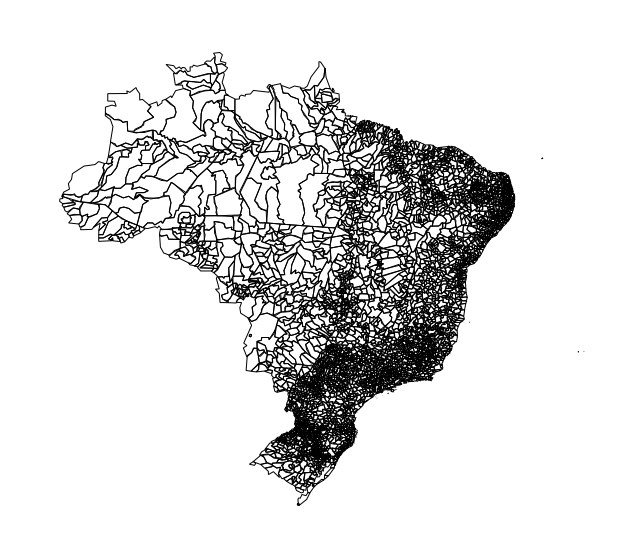

In [ ]:
gplt.polyplot(malha, figsize=(20, 10))

---

## Distribuição

### Histograma

<AxesSubplot:xlabel='IDEB_AI', ylabel='Count'>

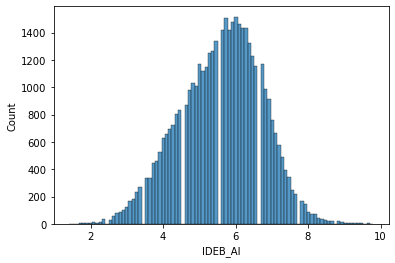

In [ ]:
sns.histplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI")

<AxesSubplot:xlabel='IDEB_AI', ylabel='Count'>

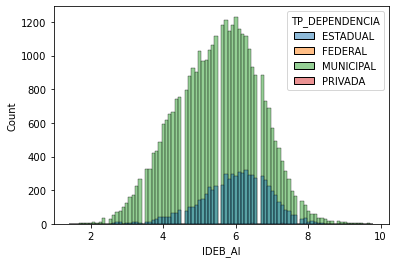

In [ ]:
sns.histplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI", hue="TP_DEPENDENCIA")

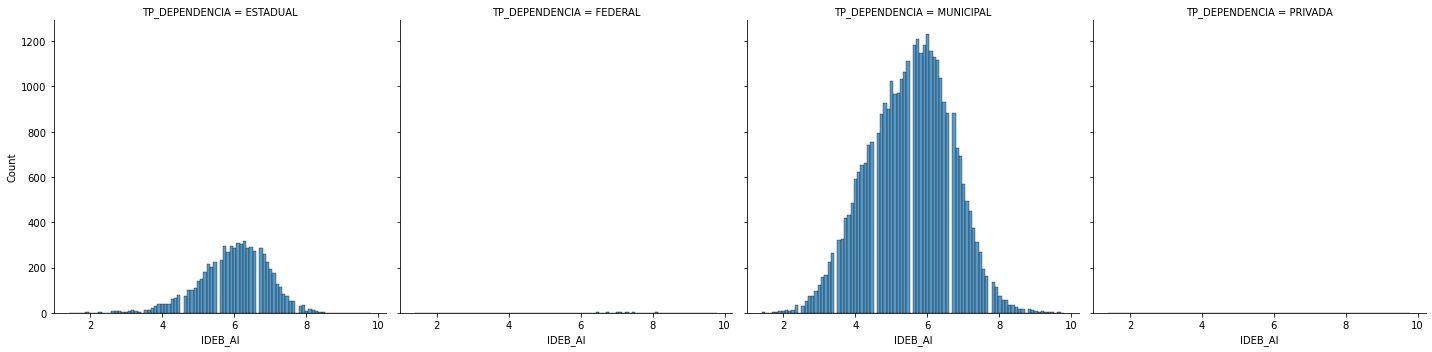

In [ ]:
sns.displot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI", col="TP_DEPENDENCIA")

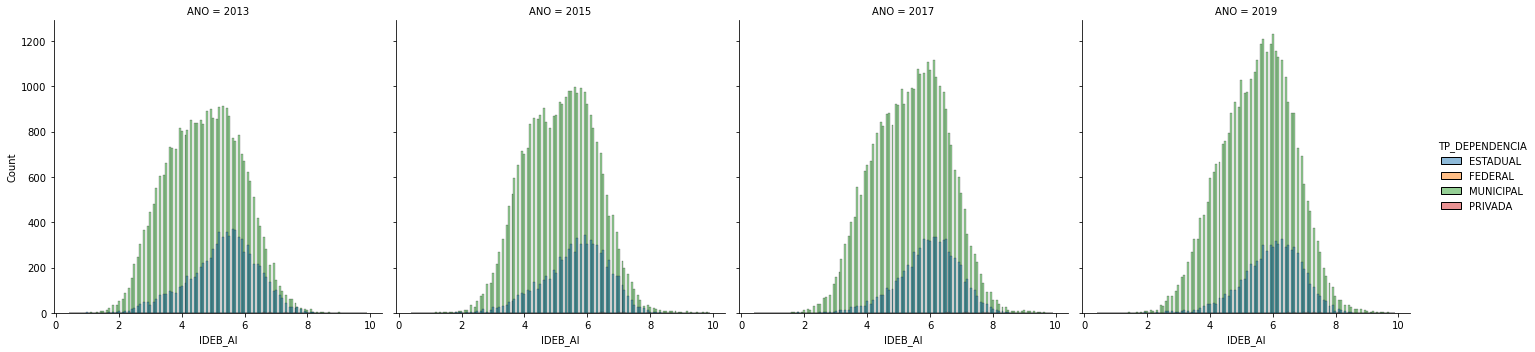

In [ ]:
sns.displot(
    data=dm.loc[lambda f: f["ANO"].isin([2013, 2015, 2017, 2019])]
    .assign(ANO=lambda f: f["ANO"].astype("int")),
    x="IDEB_AI",
    hue="TP_DEPENDENCIA",
    col="ANO"
)

### Trama de Tapate

<AxesSubplot:xlabel='IDEB_AI'>

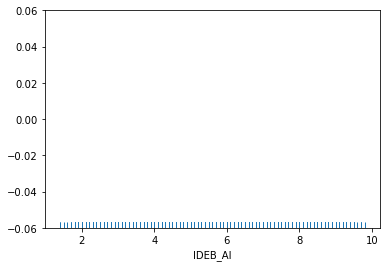

In [ ]:
sns.rugplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI")

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO'>

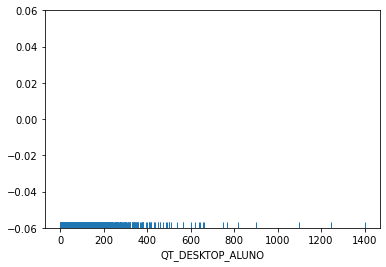

In [ ]:
sns.rugplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="QT_DESKTOP_ALUNO")

### Densidade (Kernel Density Estimator)

<AxesSubplot:xlabel='IDEB_AI', ylabel='Density'>

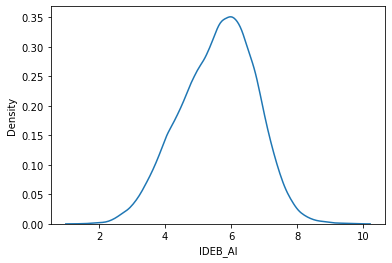

In [ ]:
sns.kdeplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI")

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



<AxesSubplot:xlabel='IDEB_AI', ylabel='Density'>

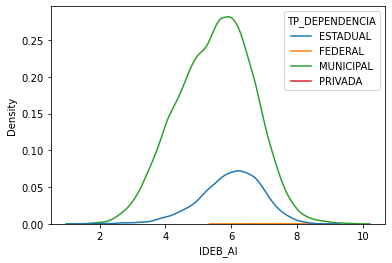

In [ ]:
sns.kdeplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI", hue="TP_DEPENDENCIA")

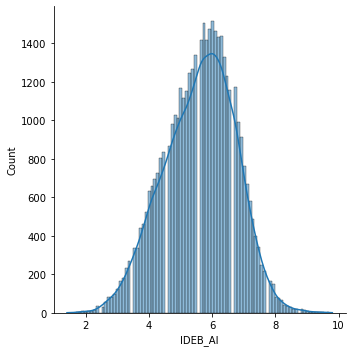

In [ ]:
sns.displot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI", kde=True)

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO', ylabel='Density'>

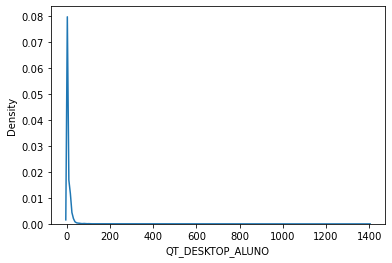

In [ ]:
sns.kdeplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="QT_DESKTOP_ALUNO")

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO', ylabel='Count'>

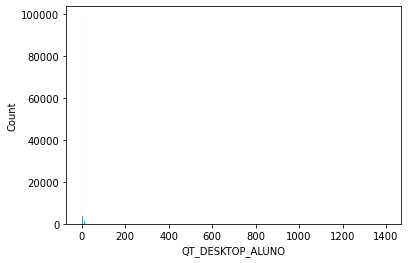

In [ ]:
sns.histplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="QT_DESKTOP_ALUNO")

### Frequencia Cumulativa (ECDF)

<AxesSubplot:xlabel='IDEB_AI', ylabel='Proportion'>

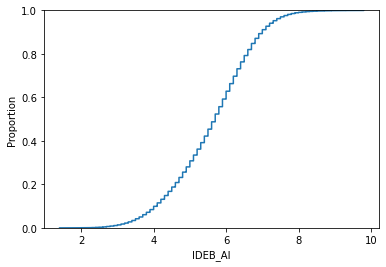

In [ ]:
sns.ecdfplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI")

<AxesSubplot:xlabel='IDEB_AI', ylabel='Proportion'>

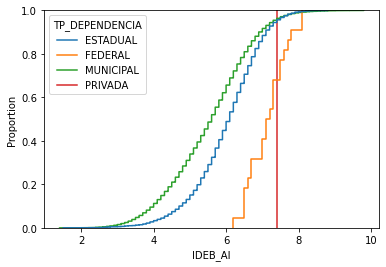

In [ ]:
sns.ecdfplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="IDEB_AI", hue="TP_DEPENDENCIA")

---

## Partes do Todo

### Barras de contagem

<AxesSubplot:xlabel='TP_DEPENDENCIA', ylabel='count'>

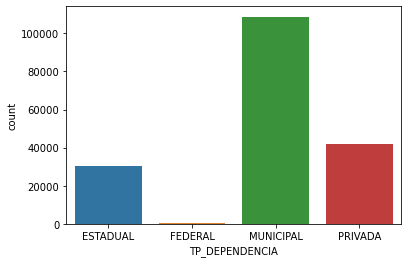

In [ ]:
sns.countplot(data=dm.loc[lambda f: f["ANO"] == 2020], x="TP_DEPENDENCIA")

### Barras Empilhadas

In [ ]:
pv = dm.pivot_table(
    index="ANO",
    columns="TP_DEPENDENCIA",
    values="IDEB_AI",
    aggfunc="count"
)

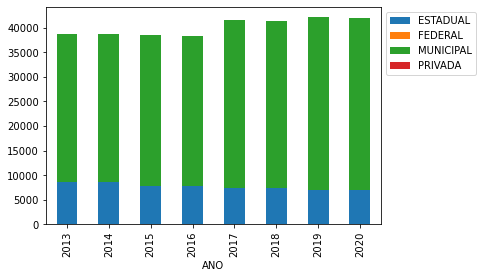

In [ ]:
ax = pv.plot(kind="bar", stacked=True)
ax.legend(bbox_to_anchor=[0.3, 0, 1, 1], loc=1)

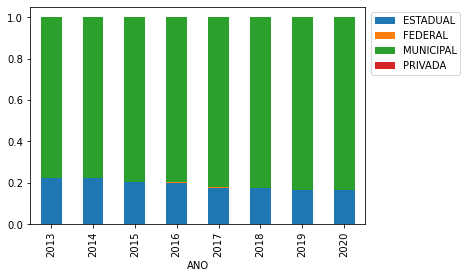

In [ ]:
ax = pv.divide(pv.sum(axis=1), axis=0).plot(kind="bar", stacked=True)
ax.legend(bbox_to_anchor=[0.3, 0, 1, 1], loc=1)

### Área

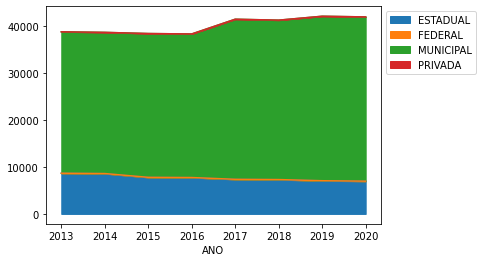

In [ ]:
ax = pv.plot(kind="area", stacked=True)
ax.legend(bbox_to_anchor=[0.3, 0, 1, 1], loc=1)

### Pizza

<AxesSubplot:>

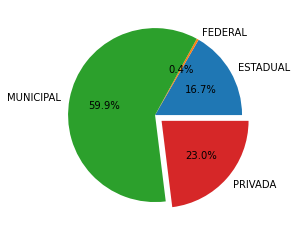

In [ ]:
dm.loc[lambda f: (f["ANO"] == 2020)].groupby(["TP_DEPENDENCIA"])["ID_ESCOLA"].count().plot(
    kind="pie", autopct="%1.1f%%", explode=(0, 0, 0, 0.1), ylabel=""
)

### Marimekko (Treemap)

TP_DEPENDENCIA
ESTADUAL      3933
FEDERAL         80
MUNICIPAL    16384
PRIVADA       1824
Name: ID_ESCOLA, dtype: int64

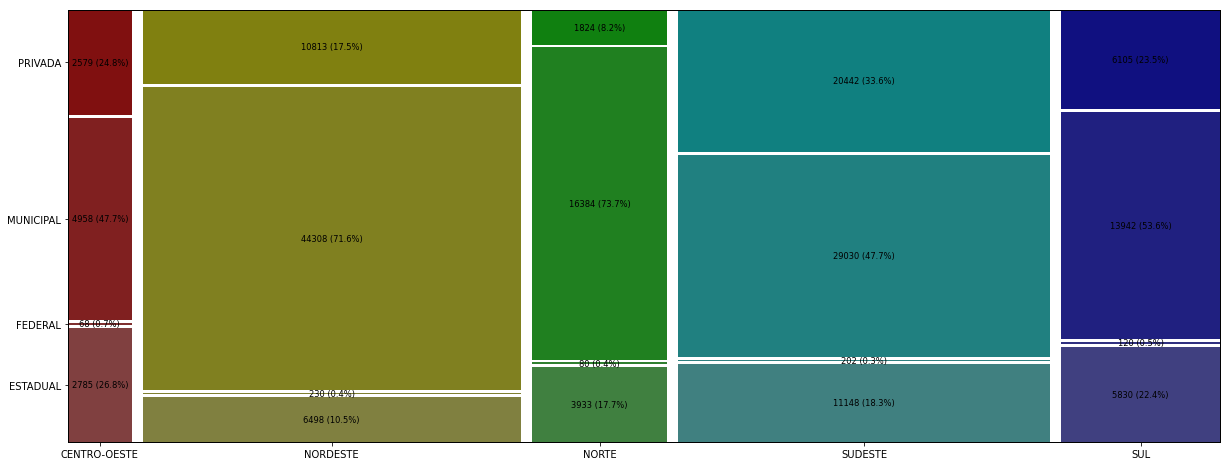

In [ ]:
dados = (
    dm.loc[lambda f: (f["ANO"] == 2020)]
    .assign(TP_DEPENDENCIA=lambda f: f["TP_DEPENDENCIA"].astype(str))
    .groupby(["NM_REGIAO", "TP_DEPENDENCIA"])["ID_ESCOLA"].count()
)

fig = plt.Figure(figsize=(16, 6))
ax = fig.add_axes([0, 0, 1, 1])
_ = mosaic(
    dados,
    ax=ax,
    gap=0.01,
    labelizer=lambda x: "%d (%.1f%%)" % (
        dados.loc[x],
        100 * dados.loc[x] / dados.loc[x[0]].sum()
    )
)
fig

### Diagrama de Venn

Sem nenhum 931


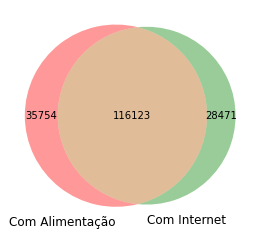

In [ ]:
dados = dm.loc[lambda f: f["ANO"] == 2020]
grupo_1 = set(dados.loc[lambda f: f["IN_ALIMENTACAO"] == 1, "ID_ESCOLA"])
grupo_2 = set(dados.loc[lambda f: f["IN_INTERNET"] == 1, "ID_ESCOLA"])
grupo_vazio = (
    dados.loc[lambda f: f["IN_ALIMENTACAO"] == 0]
    .loc[lambda f: f["IN_INTERNET"] == 0]
    .shape[0]
)
print("Sem nenhum", grupo_vazio)
_ = venn2(subsets=[grupo_1, grupo_2], set_labels=("Com Alimentação", "Com Internet"))

Sem nenhum 625


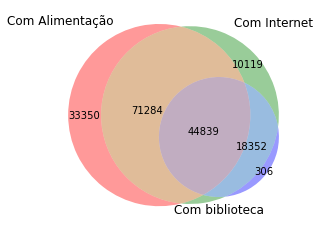

In [ ]:
dados = dm.loc[lambda f: f["ANO"] == 2020]
grupo_1 = set(dados.loc[lambda f: f["IN_ALIMENTACAO"] == 1, "ID_ESCOLA"])
grupo_2 = set(dados.loc[lambda f: f["IN_INTERNET"] == 1, "ID_ESCOLA"])
grupo_3 = set(dados.loc[lambda f: f["IN_BIBLIOTECA"] == 1, "ID_ESCOLA"])
grupo_vazio = (
    dados.loc[lambda f: f["IN_ALIMENTACAO"] == 0]
    .loc[lambda f: f["IN_INTERNET"] == 0]
    .loc[lambda f: f["IN_BIBLIOTECA"] == 0]
    .shape[0]
)
print("Sem nenhum", grupo_vazio)
_ = venn3(subsets=[grupo_1, grupo_2, grupo_3], set_labels=("Com Alimentação", "Com Internet", "Com biblioteca"))

---

## Disperção

### Dispersão

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO', ylabel='IDEB_AI'>

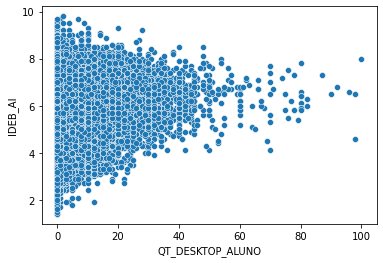

In [ ]:
sns.scatterplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI"
)

### Jointplot

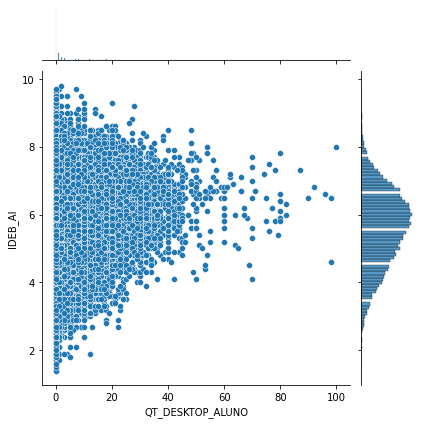

In [ ]:
sns.jointplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI"
)

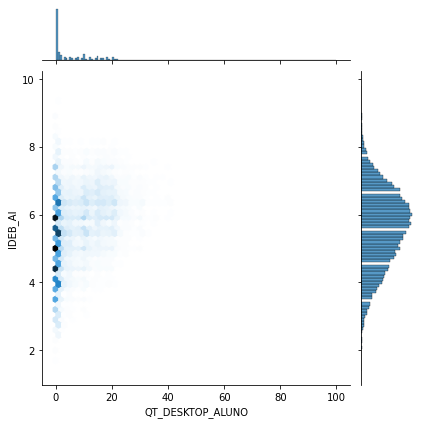

In [ ]:
sns.jointplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    kind="hex"
)

### Pairplot

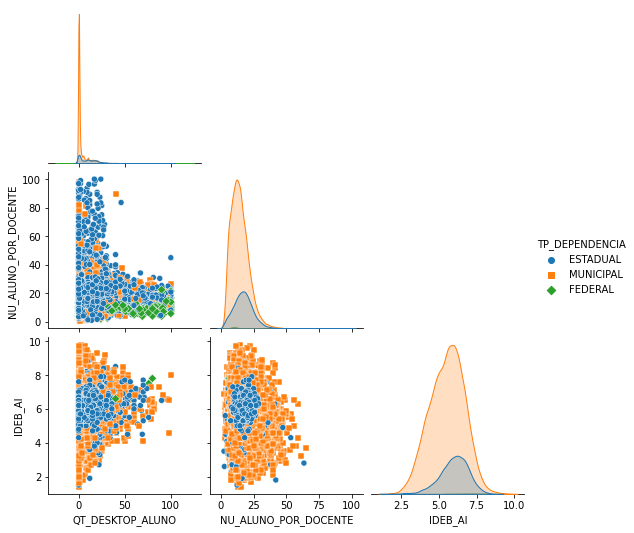

In [ ]:
sns.pairplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100]
    .loc[lambda f: f["NU_ALUNO_POR_DOCENTE"] <= 100]
    .loc[lambda f: f["TP_DEPENDENCIA"] != "PRIVADA"]
    .assign(TP_DEPENDENCIA=lambda f: f["TP_DEPENDENCIA"].astype(str))
    .reindex(columns=["TP_DEPENDENCIA", "QT_DESKTOP_ALUNO", "NU_ALUNO_POR_DOCENTE", "IDEB_AI"]),
    hue="TP_DEPENDENCIA",
    corner=True,
    markers=["o", "s", "D"]
)

### Bolhas

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO', ylabel='NU_ALUNO_POR_DOCENTE'>

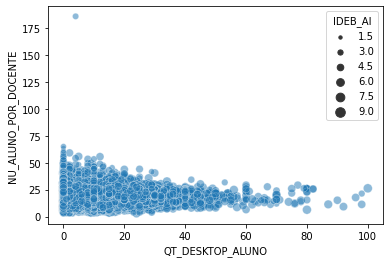

In [ ]:
sns.scatterplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="NU_ALUNO_POR_DOCENTE",
    size="IDEB_AI",
    sizes=(10, 100),
    alpha=0.5,
)

### Curvas de Nível

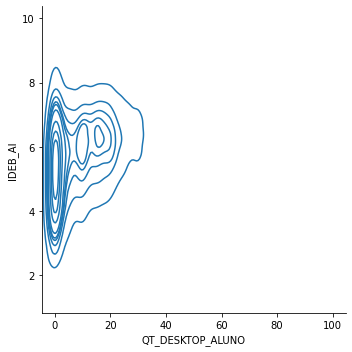

In [ ]:
sns.displot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    kind="kde"
)

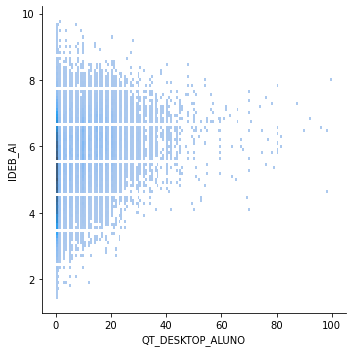

In [ ]:
sns.displot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    kind="hist"
)

---

## Numéricas

### Linha

<AxesSubplot:xlabel='ANO'>

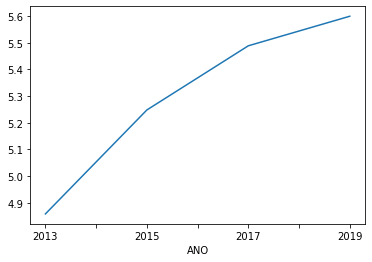

In [ ]:
(
    dm.groupby(["ANO"])["IDEB_AI"].mean()
    .loc[[2013, 2015, 2017, 2019]]
    .plot()
)

<AxesSubplot:xlabel='ANO'>

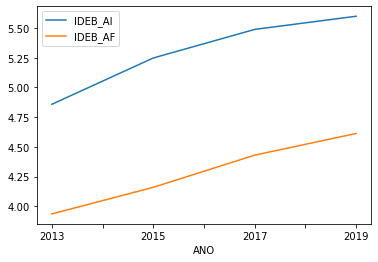

In [ ]:
(
    dm.groupby(["ANO"])[["IDEB_AI", "IDEB_AF"]].mean()
    .loc[[2013, 2015, 2017, 2019]]
    .plot()
)

###  Regressão Linear

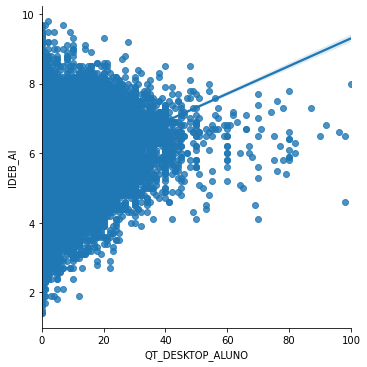

In [ ]:
sns.lmplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI"
)

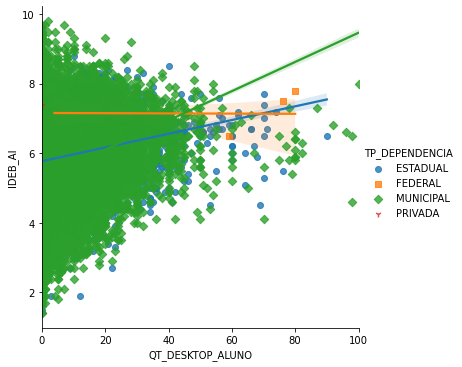

In [ ]:
sns.lmplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    hue="TP_DEPENDENCIA",
    markers=["o", "s", "D", "1"]
)

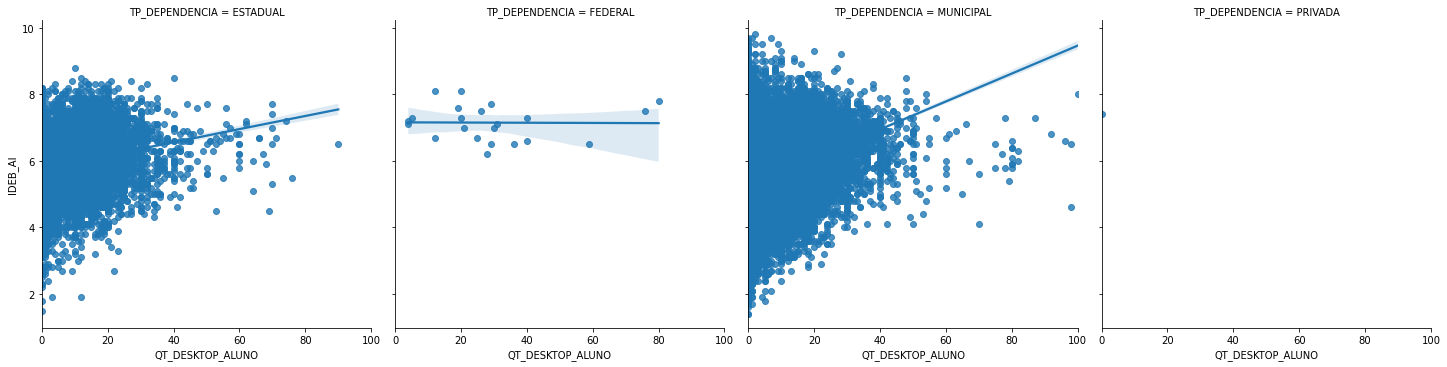

In [ ]:
sns.lmplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    col="TP_DEPENDENCIA",
)

### Estimativa Discreta

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO', ylabel='IDEB_AI'>

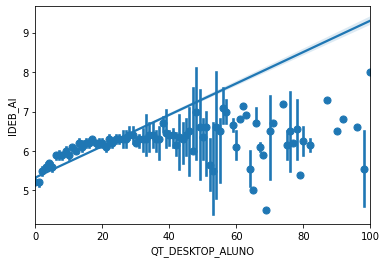

In [ ]:
sns.regplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    x_estimator=np.median,
)

### Regressão Polinomial

<AxesSubplot:xlabel='QT_DESKTOP_ALUNO', ylabel='IDEB_AI'>

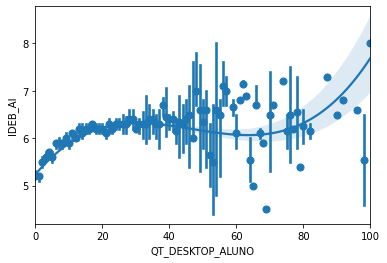

In [ ]:
sns.regplot(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100],
    x="QT_DESKTOP_ALUNO",
    y="IDEB_AI",
    order=3,
    x_estimator=np.median,
)

---

## Categóricas

### Diagrama de Caixa

<AxesSubplot:xlabel='IN_BIBLIOTECA', ylabel='IDEB_AI'>

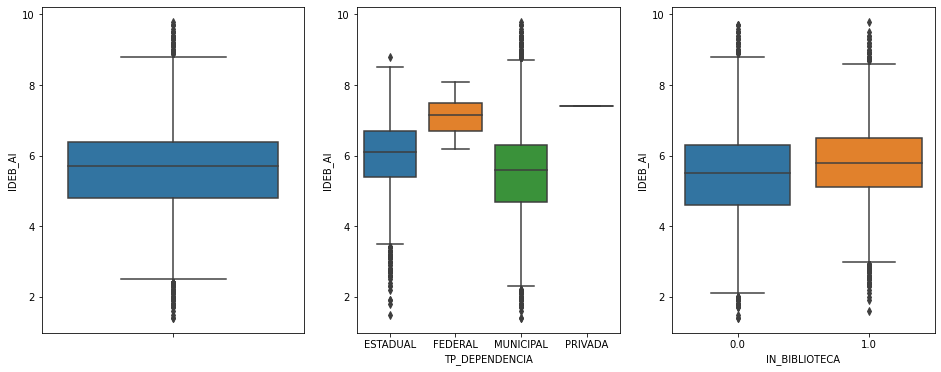

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(16, 6))
sns.boxplot(ax=axes[0], data=dm.loc[lambda f: f["ANO"] == 2020], y="IDEB_AI")
sns.boxplot(ax=axes[1], data=dm.loc[lambda f: f["ANO"] == 2020], x="TP_DEPENDENCIA", y="IDEB_AI")
sns.boxplot(ax=axes[2], data=dm.loc[lambda f: f["ANO"] == 2020], x="IN_BIBLIOTECA", y="IDEB_AI")

### Diagrama de Violino

<AxesSubplot:xlabel='IN_BIBLIOTECA', ylabel='IDEB_AI'>

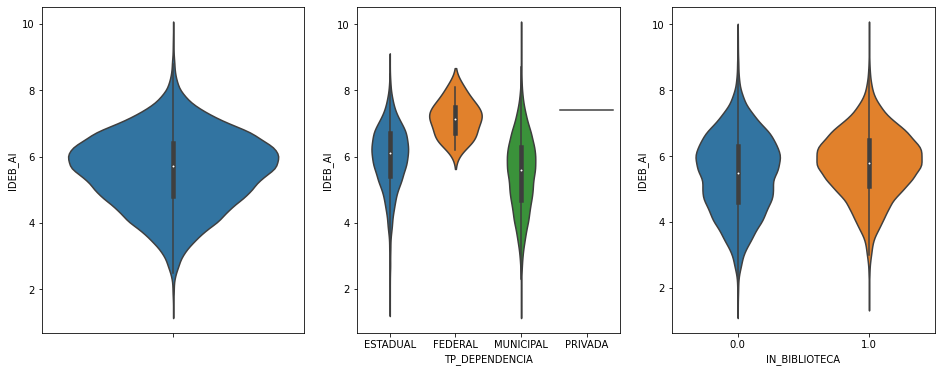

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(16, 6))
sns.violinplot(ax=axes[0], data=dm.loc[lambda f: f["ANO"] == 2020], y="IDEB_AI")
sns.violinplot(ax=axes[1], data=dm.loc[lambda f: f["ANO"] == 2020], x="TP_DEPENDENCIA", y="IDEB_AI")
sns.violinplot(ax=axes[2], data=dm.loc[lambda f: f["ANO"] == 2020], x="IN_BIBLIOTECA", y="IDEB_AI")

### Trama de Tira

<AxesSubplot:xlabel='IN_BIBLIOTECA', ylabel='IDEB_AI'>

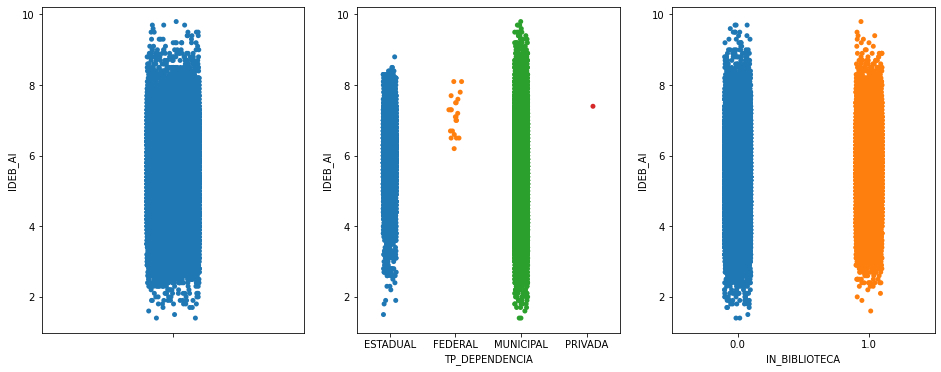

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(16, 6))
sns.stripplot(ax=axes[0], data=dm.loc[lambda f: f["ANO"] == 2020], y="IDEB_AI")
sns.stripplot(ax=axes[1], data=dm.loc[lambda f: f["ANO"] == 2020], x="TP_DEPENDENCIA", y="IDEB_AI")
sns.stripplot(ax=axes[2], data=dm.loc[lambda f: f["ANO"] == 2020], x="IN_BIBLIOTECA", y="IDEB_AI")

### Point Plot

<AxesSubplot:xlabel='IN_BIBLIOTECA', ylabel='IDEB_AI'>

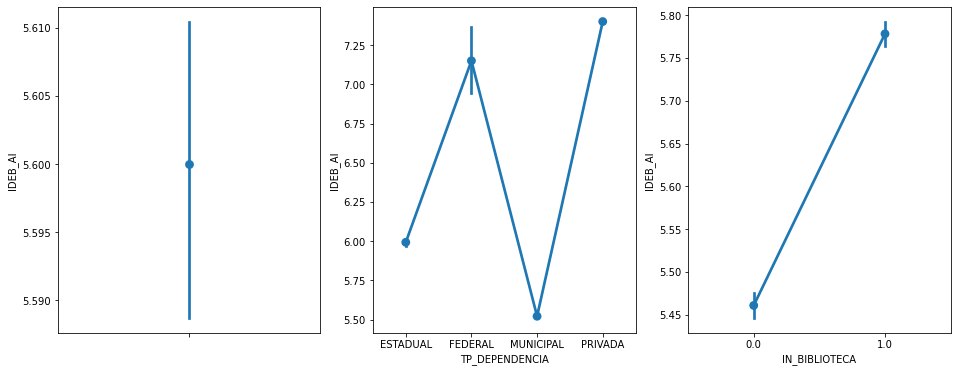

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(16, 6))
sns.pointplot(ax=axes[0], data=dm.loc[lambda f: f["ANO"] == 2020], y="IDEB_AI")
sns.pointplot(ax=axes[1], data=dm.loc[lambda f: f["ANO"] == 2020], x="TP_DEPENDENCIA", y="IDEB_AI")
sns.pointplot(ax=axes[2], data=dm.loc[lambda f: f["ANO"] == 2020], x="IN_BIBLIOTECA", y="IDEB_AI")

### Barras

<AxesSubplot:xlabel='TP_DEPENDENCIA', ylabel='IDEB_AI'>

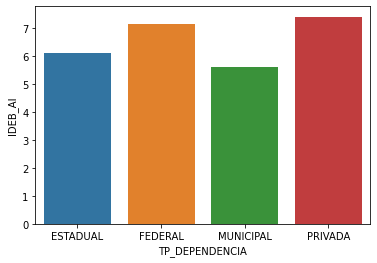

In [ ]:
dados = dm.loc[lambda f: f["ANO"] == 2020].groupby(["TP_DEPENDENCIA"])["IDEB_AI"].median().reset_index()
sns.barplot(data=dados, x="TP_DEPENDENCIA", y="IDEB_AI")

---

## Matriciais

### Mapa de Calor

<AxesSubplot:>

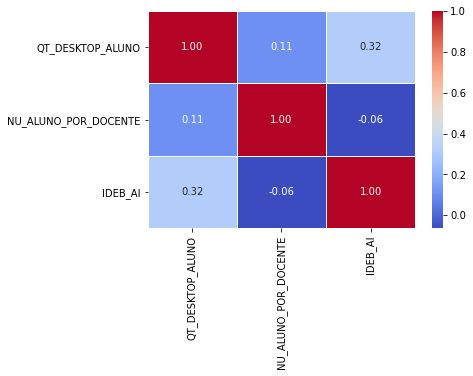

In [ ]:
sns.heatmap(
    data=dm.loc[lambda f: f["ANO"] == 2020]
    .loc[lambda f: f["QT_DESKTOP_ALUNO"] <= 100]
    .loc[lambda f: f["NU_ALUNO_POR_DOCENTE"] <= 100]
    .loc[lambda f: f["TP_DEPENDENCIA"] != "PRIVADA"]
    .reindex(columns=["QT_DESKTOP_ALUNO", "NU_ALUNO_POR_DOCENTE", "IDEB_AI"])
    .corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=.5,
)

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

<AxesSubplot:>

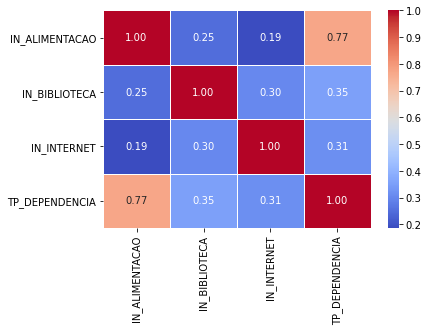

In [ ]:
dados = dm.loc[lambda f: f["ANO"] == 2020].assign(
    TP_DEPENDENCIA=lambda f: f["TP_DEPENDENCIA"].replace({
        "MUNICIPAL": 1,
        "ESTADUAL": 2,
        "FEDERAL": 3,
        "PRIVADA": 4
    })
)
cols = ["IN_ALIMENTACAO", "IN_BIBLIOTECA", "IN_INTERNET", "TP_DEPENDENCIA"]
matrix = np.zeros(shape=(len(cols), len(cols)))
for i, c1 in enumerate(cols):
    for j, c2 in enumerate(cols):
        matrix[i, j] = cramers_v(dados[c1], dados[c2])

sns.heatmap(
    data=pd.DataFrame(matrix, index=cols, columns=cols),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=.5,
)

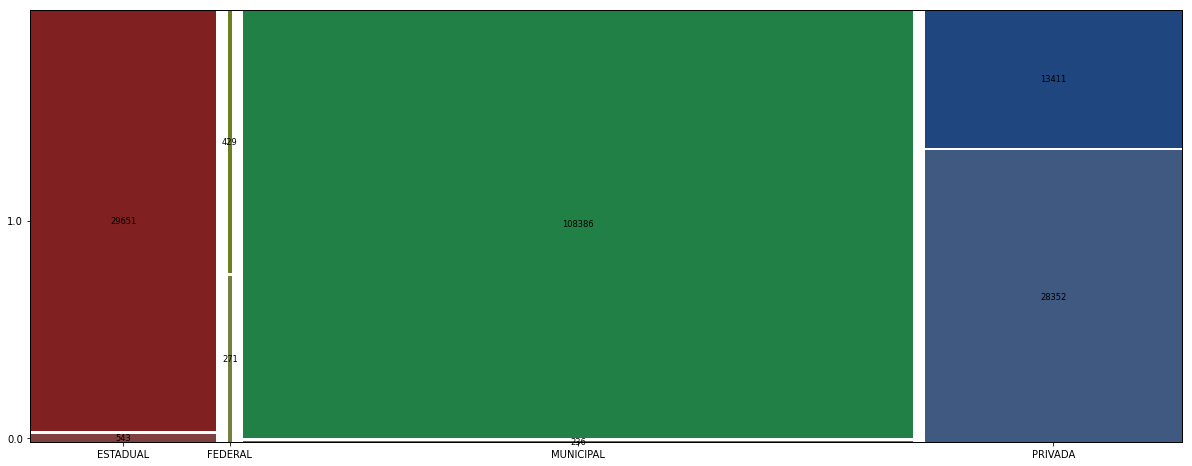

In [ ]:
fig = plt.Figure(figsize=(16, 6))
dados = (
    dm.loc[lambda f: f["ANO"] == 2020]
    .assign(
        IN_ALIMENTACAO=lambda f: f["IN_ALIMENTACAO"].astype(str),
        TP_DEPENDENCIA=lambda f: f["TP_DEPENDENCIA"].astype(str)
    )
    .groupby(["TP_DEPENDENCIA", "IN_ALIMENTACAO"])["ID_ESCOLA"].count()
)

ax = fig.add_axes([0, 0, 1, 1])
_ = mosaic(
    dados,
    ax=ax,
    gap=0.01,
    labelizer=lambda x: dados.loc[x],
)
fig

### Matriz de Cluster

---

## Geografia

In [ ]:
mun = mun_shape.assign(CD_MUN=lambda f: f["CD_MUN"].astype("int")).merge(
    dm.groupby(["CO_MUNICIPIO", "NM_REGIAO"])["IDEB_AI"].mean().reset_index(),
    left_on="CD_MUN",
    right_on="CO_MUNICIPIO",
    how="left"
)

### Point

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\geoplot\geoplot.py:66: UserWarning:

The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.



<AxesSubplot:>

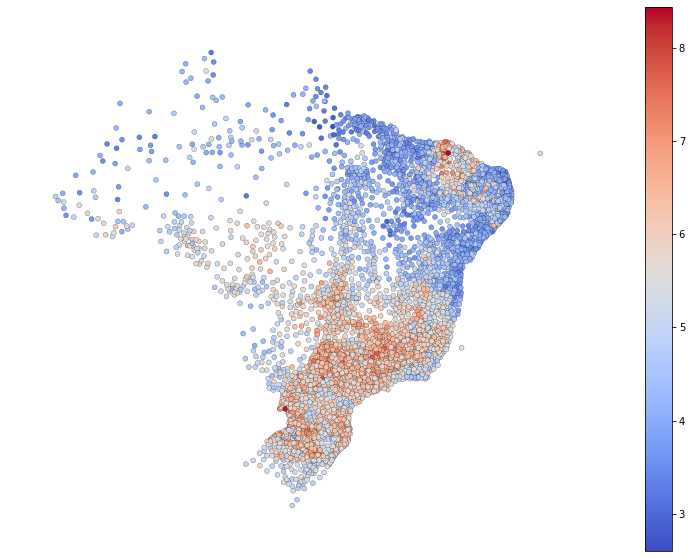

In [ ]:
gplt.pointplot(
    mun.assign(geometry=lambda f: f["geometry"].apply(lambda x: x.centroid)),
    hue="IDEB_AI",
    cmap="coolwarm",
    legend=True,
    figsize=(20, 10),
    edgecolor="black",
    linewidth=0.2
)

### Heatmap

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\geoplot\geoplot.py:66: UserWarning:

The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\geoplot\geoplot.py:1004: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



<AxesSubplot:>

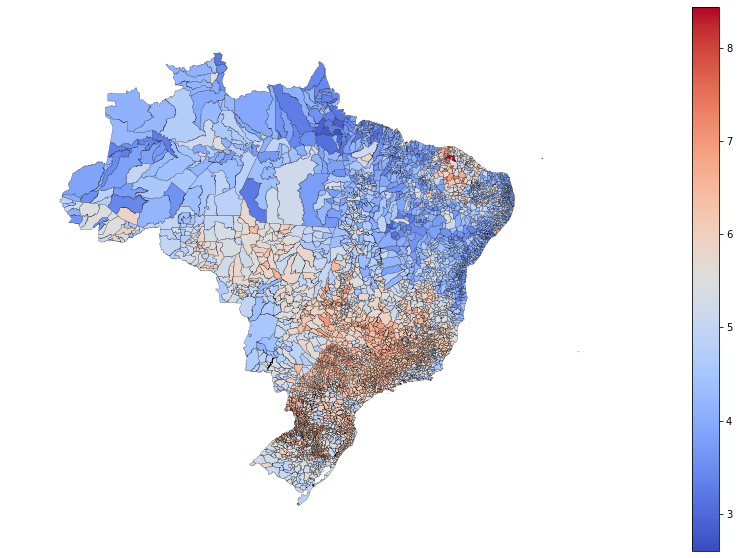

In [ ]:
gplt.choropleth(
    mun,
    hue=mun["IDEB_AI"],
    cmap="coolwarm",
    legend=True,
    figsize=(20, 10),
    edgecolor="black",
    linewidth=0.2
)

### KDE

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\envs\curso-ciencia-dados\lib\site-packages\seaborn\distributions.py:1678: UserWarning:

`shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.



<AxesSubplot:>

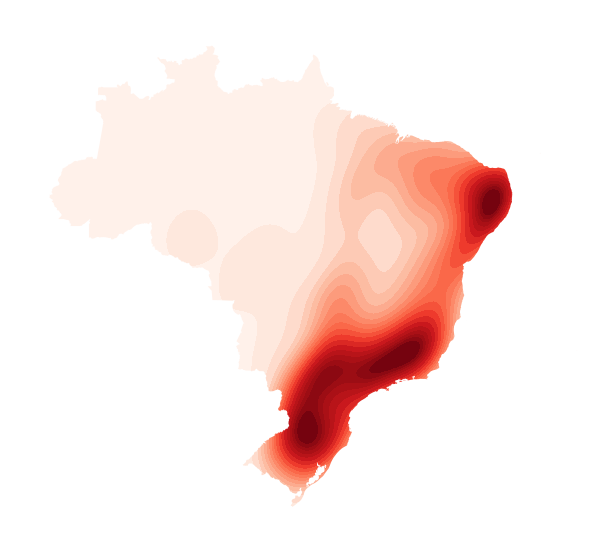

In [ ]:
ax = gplt.polyplot(uf_shape, figsize=(20, 10))
gplt.kdeplot(
    mun.assign(geometry=lambda f: f["geometry"].apply(lambda x: x.centroid)),
    ax=ax,
    n_levels=20,
    cmap="Reds",
    shade=True,
    shade_lowest=True,
    clip=uf_shape,
)

---